In [36]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, vstack, join
from glob import glob
from tqdm import tqdm

In [11]:
datadir = "data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/"

In [15]:
cubepath = "data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits"

In [16]:
mcmc_fils = glob(f"{datadir}/**/*.fits",recursive=True)

In [46]:
l = 0
for i in range(len(tables)):
    l += len(tables[i])

l

11255

In [50]:
cube = fits.open(cubepath)
binid = cube['BINID'].data[0]

table = None
for i,fil in enumerate(tqdm(mcmc_fils, desc= "Combining Tables")):
    data = fits.open(fil)
    data_table = Table(data[1].data)
    data_table.remove_columns(['samples','percentiles'])
    data_table['id'] = np.arange(len(data_table))
    if i == 0:
        table = data_table
        continue
    table = join(table, data_table, join_type='outer')

Combining Tables: 100%|█████████████████████████| 17/17 [01:04<00:00,  3.80s/it]


In [51]:
len(np.unique(table['bin']))

11239

In [52]:
table

bin,velocities,id
int32,float64,int64
0,-117.05774445619626,0
1,-108.92228269201179,1
2,-108.20174800324331,2
3,-103.41542578277829,3
4,-89.41003780472714,4
5,-94.64593482875534,5
6,-90.35757374186954,6
7,-105.30633880527027,7
8,-121.24847590488541,8


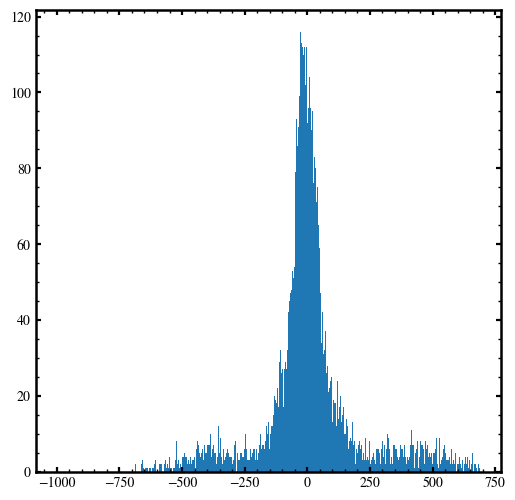

In [71]:
plt.hist(table['velocities'],bins=1000);

In [60]:
bins,inds = np.unique(table['bin'],return_index=True)

In [64]:
binid = cube['BINID'].data[0]

In [65]:
vmap = np.zeros(binid.shape)
for ID,ind in zip(bins,inds):
    w = binid == ID
    vmap[w] = table['velocities'][ind]

In [66]:
plt.style.use('figures.mplstyle')

In [78]:
round(np.std(table['velocities']),ndigits=-1)

210.0

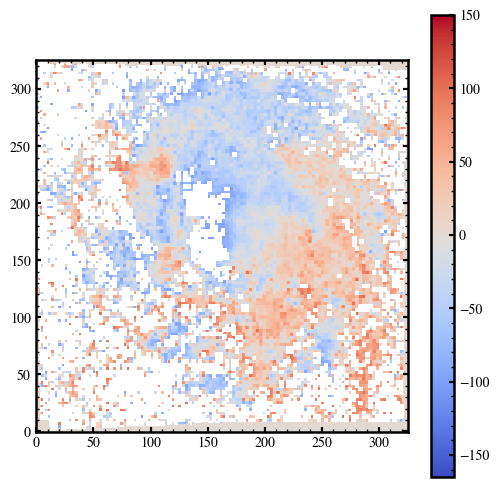

In [85]:
w = (vmap>100) | (vmap<-100)
vmap[w] = np.nan
plt.imshow(vmap,cmap='coolwarm',vmin=150,vmax=-150,origin='lower')
plt.colorbar()

In [92]:
testdir = "/Users/apitts4030/Repo/NaI_analysis/data/NGC4030/cube/BETA-CORR/"
testglob = glob(f"{testdir}/**/*.fits",recursive=True)
testglob

[]

In [93]:
testdir = "/Users/apitts4030/Repo/NaI_analysis/data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/"

In [94]:
fils = glob(os.path.join(testdir,"**","*.fits"),recursive=True)

In [97]:
for fil in fils:
    if "MAPS" in fil:
        mapfil = fil

In [99]:
Map = fits.open(mapfil)

In [106]:
Map.info()

Filename: /Users/apitts4030/Repo/NaI_analysis/data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1384   ()      
  1  SPX_SKYCOO    1 ImageHDU        44   (326, 326, 2)   float32   
  2  SPX_ELLCOO    1 ImageHDU        49   (326, 326, 4)   float32   
  3  SPX_MFLUX     1 ImageHDU        36   (326, 326)   float32   
  4  SPX_MFLUX_IVAR    1 ImageHDU        37   (326, 326)   float32   
  5  SPX_SNR       1 ImageHDU        34   (326, 326)   float32   
  6  BINID         1 ImageHDU        46   (326, 326, 5)   int32   
  7  BIN_LWSKYCOO    1 ImageHDU        44   (326, 326, 2)   float32   
  8  BIN_LWELLCOO    1 ImageHDU        49   (326, 326, 4)   float32   
  9  BIN_AREA      1 ImageHDU        35   (326, 326)   float32   
 10  BIN_FAREA     1 ImageHDU        34   (326, 326)   float32   
 11  BIN_MFLUX     1 I

In [113]:
Map['EMLINE_SFLUX'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  326                                                  
NAXIS2  =                  326                                                  
NAXIS3  =                   35                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =      168.69830612546 / Pixel coordinate of reference point            
CRPIX2  =      162.60512922633 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
PC1_1   = -5.5555555555556E-

In [91]:
import os
os.path.dirname(os.path.abspath('maps'))

'/Users/apitts4030/Repo/NaI_analysis'